### Installation instructions

__Important: use Python 3.9__

__Install graphviz:__

    * Linux: apt-get install graphviz
    * MAC OS: brew install graphviz

__Setup a virtual environment:__

```
cd arguseyes
python -m venv venv
source venv/bin/activate
```

__Install pip dependencies and build the package:__

```
pip install -r requirements.txt
pip install .
```

__Start the demo notebook server:__
```
cd arguseyes/example_pipelines
jupyter notebook
```



## The ML Pipeline to investigate

Computer vision pipeline training a convolutional neural network to distinguish between images of sneakers and ankleboots from the fashion-mnist dataset.

In [1]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('sneakers.py') as pipline_file:
    code = pipline_file.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

### Data Valuation for the Pipeline with ArgusEyes/mlinspect

We execute and instrumented the ML pipeline with ArgusEyes/mlinspect and estimate Shapley values of the input images. ArgusEyes provides us with the source data of the pipeline and appends a new attribute containing the estimated Shapley values.

In [2]:
from arguseyes import ArgusEyes
import logging
from arguseyes.refinements import DataValuation

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

eyes = ArgusEyes('demo-ce', '../../mlruns')
with eyes.classification_pipeline_from_py_file('sneakers.py') as pipeline:
    valued_source = pipeline.compute(DataValuation(k=10, num_test_samples=100))

INFO:Patching sys.argv with ['eyes']
INFO:Created run c8254d26d32248fb87b3aaf022c3d027 for this invocation
INFO:Executing instrumented user pipeline with mlinspect
INFO:Redirecting the pipeline's stdout to arguseyes-pipeline-output.txt
/Users/ssc/projects/arguseyes/venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
INFO:Identifying training sources
INFO:Found fact table from operator 0 with 6000 records and the following attributes: ['image', 'category_id']
INFO:Found dimension table from operator 1 with 10 records and the following attributes: ['category_id', 'category_name']
INFO:Identifying test sources
INFO:Found fact table from operator 0 with 6000 records and the following attributes: ['image', 'category_id']
INFO:Found d

### Extracted "Query plan" for the ML pipeline 

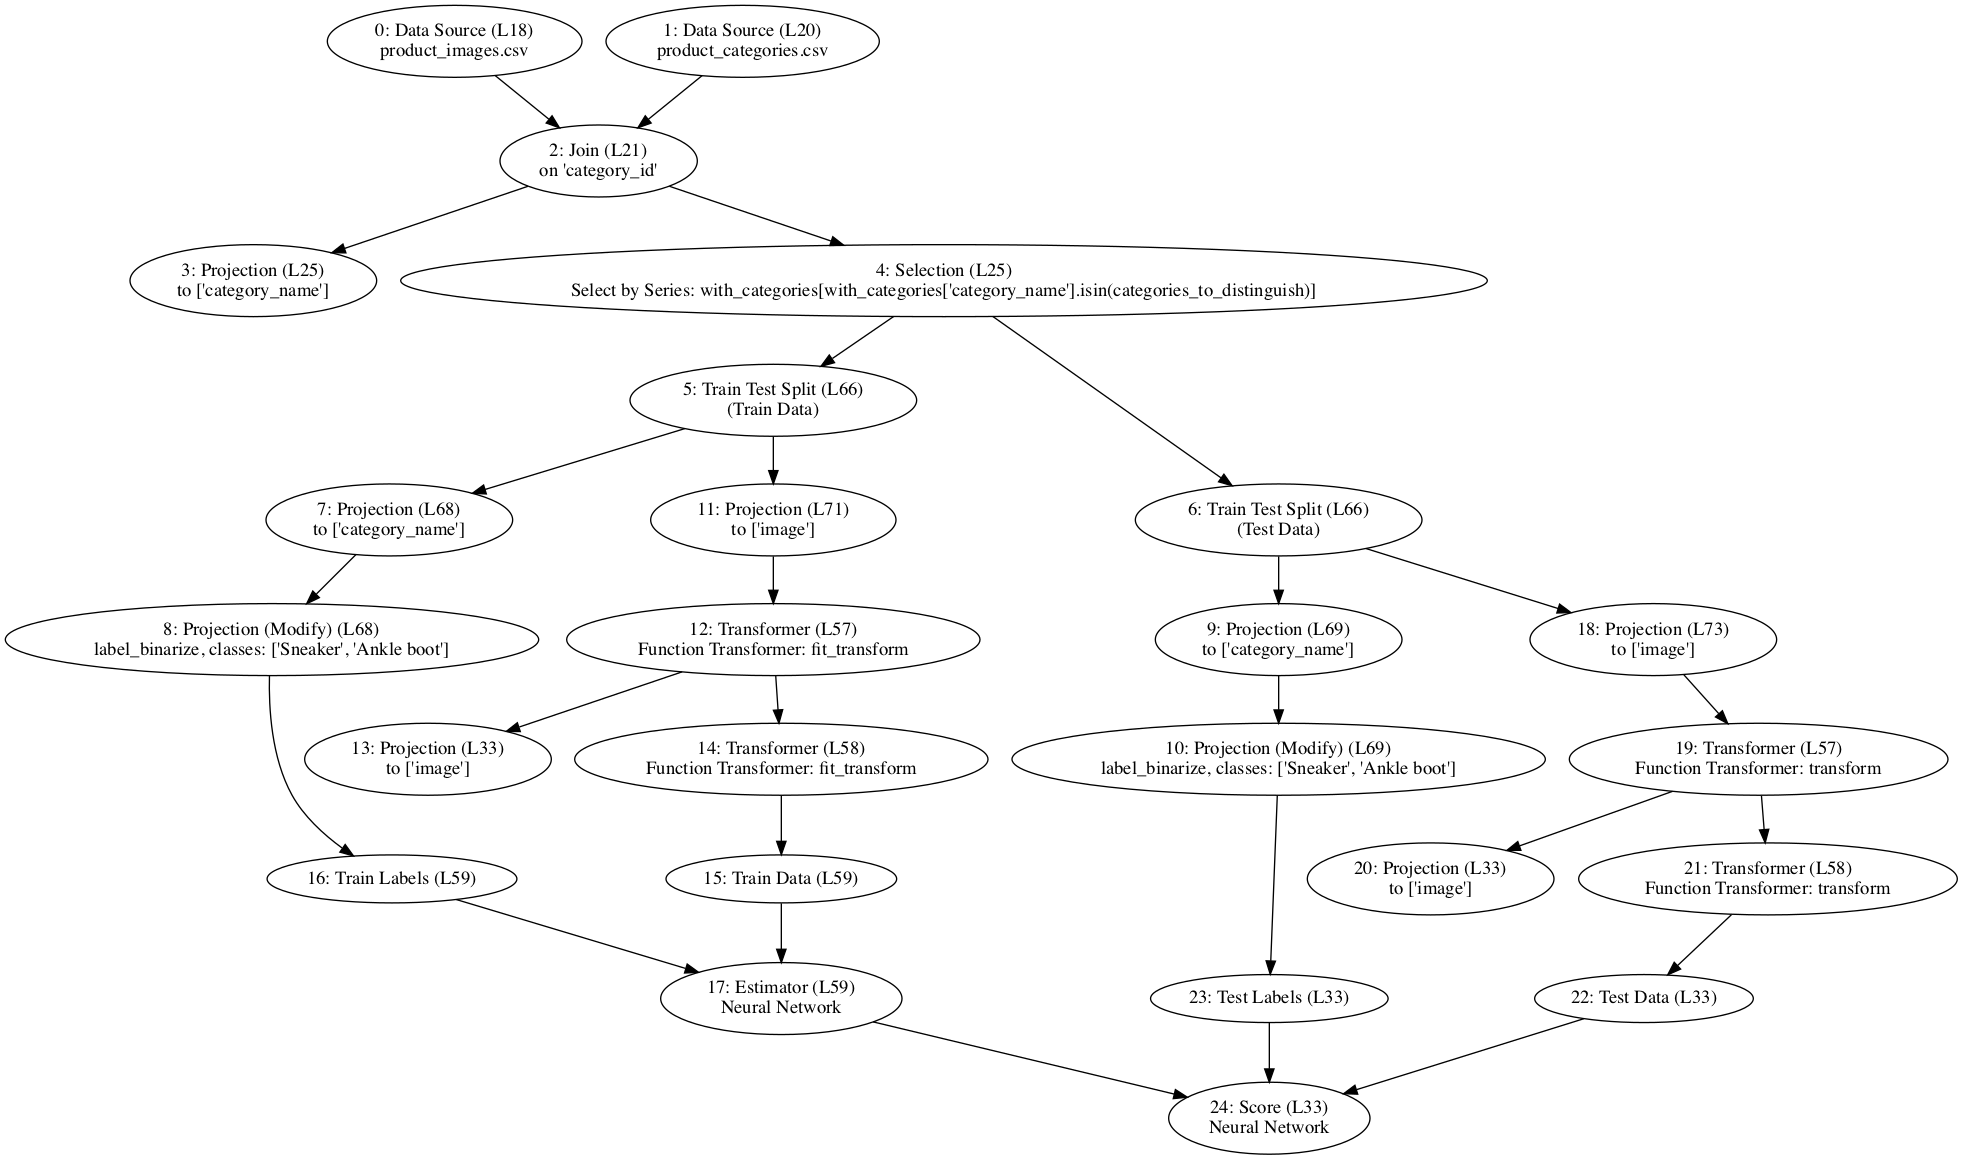

In [4]:
from IPython.display import Image
Image(filename='sneakers-dag.png')

### Top 5 least useful samples (with lowest shapley values)

Sneakers that look like ankleboots and ankleboots that look like sneakers.


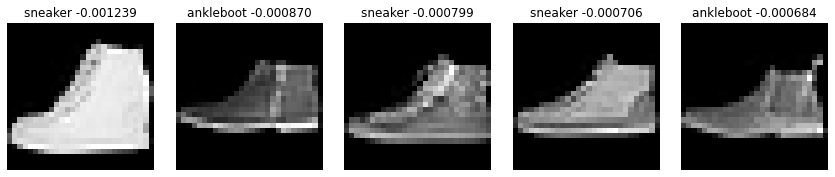

In [5]:
from matplotlib import pyplot as plt

# Sort input samples by Shapley values (from low to high)
samples_sorted_shapley_value = valued_source.data.sort_values(by='__arguseyes__shapley_value')

fig, axarr = plt.subplots(1,5)

# Investigate the five samples with the lowest scores
for index in range(0, 5):

    sample = samples_sorted_shapley_value.iloc[index]
    image_data = sample.image.reshape(28, 28)

    if sample.category_id == 9:
        category = 'ankleboot'
    else:
        category = 'sneaker' 
    
    axarr[index].imshow(image_data, cmap='gray')
    axarr[index].set_title(f"{category} {sample.__arguseyes__shapley_value:.6f}")
    axarr[index].axis('off')
    
plt.tight_layout()  
fig.set_size_inches(12, 8)

plt.show()